In [1]:
from torch import nn, optim
import torch
from torchvision import datasets, transforms
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [2]:
#Network architecture
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)

        #20% probability Dropout 
        self.dropout = nn.Dropout(p=.2)

    def forward(self, x):
        #flatten input tensor
        x = x.view(x.shape[0], -1)

        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))
        x = F.log_softmax(self.fc4(x), dim=1)
        return x

In [3]:
transform = transforms.ToTensor()

#Download and load training data
trainset = datasets.MNIST('~/.pytorch/MNIST_data/',download=True,train=True,transform=transform)
trainLoader = torch.utils.data.DataLoader(trainset, batch_size=64,shuffle=True)

#Download and load test data
testset = datasets.MNIST('~/.pytorch/MNIST_data/',download=True,train=False,transform=transform)
testLoader = torch.utils.data.DataLoader(testset, batch_size=64,shuffle=True)

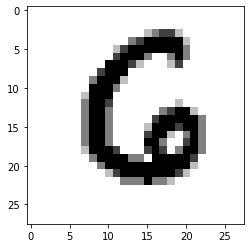

In [4]:
image, label = next(iter(trainLoader))
plt.imshow(image[0,:].reshape(28,28),cmap='binary')

In [5]:
model = Classifier()
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

epochs = 30
steps = 0
train_losses, test_losses = [], []
for e in range(epochs):
    running_loss = 0
    for imgs, labels, in trainLoader:
        logps = model(imgs)
        loss = criterion(logps, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    else:
        print(f"Training loss: {running_loss}")
        
        test_loss = 0
        acc = 0
        #Disable gradients for validation
        with torch.no_grad():
            #set model to evaluation mode (w/o dropout)
            model.eval()

            for imgs, labels in testLoader:
                log_ps = model(imgs)
                test_loss += criterion(log_ps, labels)
                #class probability
                ps = torch.exp(log_ps)
                #most likely classes
                top_p, top_class = ps.topk(1, dim=1)
                #check if top classes matches with the labels
                equals = top_class == labels.view(*top_class.shape)
                #convert 'equals' to a float tensor
                acc += torch.mean(equals.type(torch.FloatTensor))

        train_losses.append(running_loss/len(trainLoader))
        test_losses.append(test_loss/len(testLoader))
        print("Epoch: {}/{}.. ".format(e+1,epochs),
                "Training Loss: {:.3f}.. ".format(running_loss/len(trainLoader)),
                "Test Loss: {:.3f}.. ".format(test_loss/len(testLoader)),
                "Test Acc: {:.3f}.. ".format(acc/len(testLoader)))

        #set model back to train mode
        model.train()

Training loss: 288.0809283275157
Epoch: 1/30..  Training Loss: 0.307..  Test Loss: 0.130..  Test Acc: 0.962.. 
Training loss: 147.45665543805808
Epoch: 2/30..  Training Loss: 0.157..  Test Loss: 0.123..  Test Acc: 0.963.. 
Training loss: 117.33179961005226
Epoch: 3/30..  Training Loss: 0.125..  Test Loss: 0.112..  Test Acc: 0.969.. 
Training loss: 101.85691501328256
Epoch: 4/30..  Training Loss: 0.109..  Test Loss: 0.084..  Test Acc: 0.977.. 
Training loss: 94.13051783083938
Epoch: 5/30..  Training Loss: 0.100..  Test Loss: 0.086..  Test Acc: 0.976.. 
Training loss: 84.15320777520537
Epoch: 6/30..  Training Loss: 0.090..  Test Loss: 0.089..  Test Acc: 0.978.. 
Training loss: 82.76181438367348
Epoch: 7/30..  Training Loss: 0.088..  Test Loss: 0.085..  Test Acc: 0.977.. 
Training loss: 75.94218093436211
Epoch: 8/30..  Training Loss: 0.081..  Test Loss: 0.086..  Test Acc: 0.978.. 
Training loss: 75.02457668608986
Epoch: 9/30..  Training Loss: 0.080..  Test Loss: 0.080..  Test Acc: 0.979..

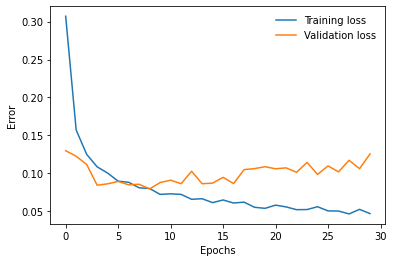

In [6]:
#Plot Train and Validation loss
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)
plt.xlabel('Epochs')
plt.ylabel('Error')
plt.show()

In [7]:
#Save model to file
torch.save(model.state_dict(), 'checkpoint.pth')
print("Model:' \n\n", model, '\n')
print("The state dict keys: \n\n", model.state_dict().keys())

Model:' 

 Classifier(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
) 

The state dict keys: 

 odict_keys(['fc1.weight', 'fc1.bias', 'fc2.weight', 'fc2.bias', 'fc3.weight', 'fc3.bias', 'fc4.weight', 'fc4.bias'])
